In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#3 tdl.m returns the observed data at the output of a tapped delay line given specs on the taps and the input sequence.

In [ ]:
def gen_signal(A):
    

In [134]:
def gen_bpsk(N=1):
    return 1 - (np.random.uniform(size=N) > 0.5).astype(np.int32)*2

def gen_qpsk(N=1):
    return gen_bpsk(N) + 1j*gen_bpsk(N)

In [137]:
def tdl(I, f=[1], var=0, SpS=1):
    N = len(I)
    L = len(f) - 1
    # upsample input
    Input = np.zeros(SpS*N, dtype=np.complex)
    Input[0::SpS] = I
    # pad input with zeros
    v = np.zeros(SpS*N + L)
    for i in np.arange(L+1):
        v = v + f[i]*np.hstack([np.zeros(i), Input, np.zeros(L-i)])
    if var > 0:
        if np.abs(np.imag(v)).sum() > 0: # then data is complex
            var = var/np.sqrt(2)
            v = v + 1j*np.sqrt(var)*np.random.normal(size=len(v))
        v = v + np.sqrt(var)*np.random.normal(size=len(v))
    return v

In [138]:
x = [-1,1,1,1,-1]
print(tdl(x, [-2,3], 0))

[ 2.+0.j -5.+0.j  1.+0.j  1.+0.j  5.+0.j -3.+0.j]


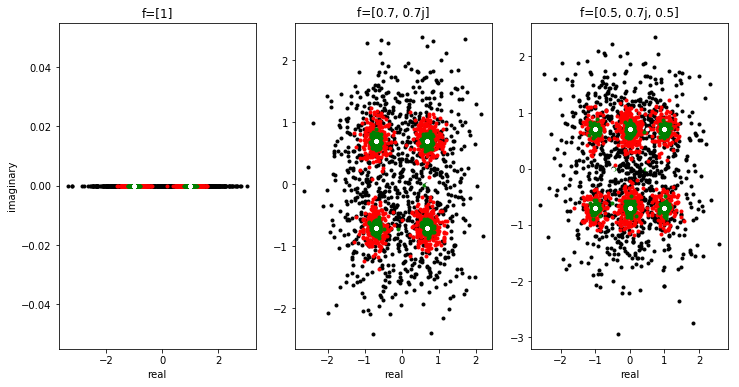

In [139]:
fig = plt.figure(figsize=(12,6))
x = gen_bpsk(N=1000)
for var,color in zip([.5, .05,.005,.0],[".k", ".r",".g",".w"]):
    r1 = tdl(x, f=[1], var=var)
    r2 = tdl(x, f=[0.7, 0.7j], var=var)
    r3 = tdl(x, f=[0.5, 0.7j, 0.5], var=var)
    p1 = plt.subplot(1,3,1)
    plt.plot(np.real(r1), np.imag(r1), color)
    plt.title("f=[1]")
    plt.xlabel("real")
    plt.ylabel("imaginary")
    plt.subplot(1,3,2)
    plt.plot(np.real(r2), np.imag(r2), color)
    plt.title("f=[0.7, 0.7j]")
    plt.xlabel("real")
    plt.subplot(1,3,3)
    plt.plot(np.real(r3), np.imag(r3), color)
    plt.title("f=[0.5, 0.7j, 0.5]")
    plt.xlabel("real")


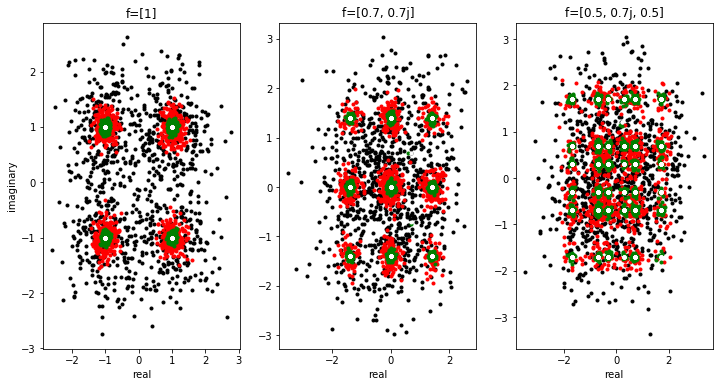

In [140]:
fig = plt.figure(figsize=(12,6))
x = gen_qpsk(N=1000)
for var,color in zip([.5, .05,.005,.0],[".k", ".r",".g",".w"]):
    r1 = tdl(x, f=[1], var=var)
    r2 = tdl(x, f=[0.7, 0.7j], var=var)
    r3 = tdl(x, f=[0.5, 0.7j, 0.5], var=var)
    p1 = plt.subplot(1,3,1)
    plt.plot(np.real(r1), np.imag(r1), color)
    plt.title("f=[1]")
    plt.xlabel("real")
    plt.ylabel("imaginary")
    plt.subplot(1,3,2)
    plt.plot(np.real(r2), np.imag(r2), color)
    plt.title("f=[0.7, 0.7j]")
    plt.xlabel("real")
    plt.subplot(1,3,3)
    plt.plot(np.real(r3), np.imag(r3), color)
    plt.title("f=[0.5, 0.7j, 0.5]")
    plt.xlabel("real")

In [223]:
def baseM2dec(s, M, L):
    fact = 1
    n = 0
    for i in (np.arange(L)[::-1]):
        n = n + s[i]*fact
        fact *= M
    return n

def dec2baseM(n, M, L):
    s = np.zeros(L, dtype=np.int)
    for i in (np.arange(L)[::-1]):
        s[i] = np.remainder(n, M)
        n = (n-s[i])/M
    return s

In [225]:
s = [1,2,3,4,5,6,]
n = 10
print(baseM2dec(s, 4, len(s)))
print(dec2baseM(n, 4, len(s)))

1818
[0 0 0 0 2 2]


In [245]:
#function [I,dmin] = va(v,f,A,SpS)
def va(v, f, A):
    ''' va - Equalization using the Viterbi algorithm 
    Given an observed sequence v, the tap gains of the FIR filter f, and
    the alphabet of symbols A, i.e., a vector containing al possible input
    symbols, the most likely sequence of input symbols is computed using
    the Viterbi algorithm. The minimum distance dis also returned. The
    parameter SpS denotes the number of samples per symbol.
    '''
    # fileter order
    Lf = len(f)
    
    # Initialization
    # Alphabet size
    M = len(A)
    # Number of "additional" symbol periods spanned by ISI
    L = Lf-1
    # Number of input symbols
    N = len(v)-Lf
    # Create storage for large arrays
    short = np.zeros([M**L,N])
    survivor = short

    # Set up tables defining for each possible transition:
    #
    #    - Initial state number, init (element of {0,1,...,M^L-1})
    #    - Final state number, final (element of {0,1,...,M^L-1})
    #    - new symbol, ns (element of A)
    #    - reconstructed signal value, v_hat
    #    - register contents after transition
    #
    #
    # Enumerate all possible transitions and assign corresponding input symbols
    # through functions dec2baseM and baseM2dec
    #

    # initialize vectors
    ns = np.zeros(M**(L+1))
    init = np.zeros(M**(L+1), dtype=np.int)
    final = np.zeros(M**(L+1), dtype=np.int)
    v_hat = np.zeros(M**(L+1))
    contents = np.zeros([M**(L+1), L])

    for i in np.arange(M**(L+1)):
        b = dec2baseM(i-1,M,L+1) # Find the base M representation of i-1 corresponding symbols
        s = A[b]
        ns[i] = s[0] # new symbol
        init[i] = baseM2dec(b[0:L],M,L) # ID number of initial state
        final[i] = baseM2dec(b[0:L],M,L) # ID number of final state
        #v_hat[i] = s*f[0:]
        contents[final[i],0:L] = s[0:L] # register contents, oldest bit is in L-th position

    #
    # The registers are initially empty. The first L symbols load the registers
    # already producing outputs. Thus, we can compute the distance for each of 
    # the M^L possible sequences and assign each of these to the proper state.
    #
    last = np.zeros([M**L, L], dtype=np.complex)
    dist = np.zeros(M**L)        

    for i in np.arange(M**L):
        s = contents[i,0:L][::-1]
        out = tdl(s,f,0)
        print(out)
        first = out[0:L]
        last[i,0:L] = out[L:2*L]
        dist[i] = np.linalg.norm(first-v[0:L])**2
        survivor[i,0:L] = s

    #
    # The main recursion of the Viterbi Algorithm
    #
    print(L)
    print(N)
    for i in np.arange(L,N):
        print(i)
        new_dist = np.inf*np.ones(M**L);   # Initialize with large values
        for t in np.arange(M**(L+1)): # Loop over all transitions
            update = dist[init[t]] + np.linalg.norm(v[i]-v_hat[t,:])**2; 
            # Compute distance resulting from transition
            if new_dist[final[t]] > update:
                new_dist[final[t]] = update
                short[final[t],0:i-1] = survivor[init[t],0:i-1]
                short[final[t],i] = ns[t]
        dist = new_dist
        survivor = short        
        
        
A = np.arange(3)-10 #[-2,1,1,2]
x = [1,2] #gen_bpsk(5)
f = [1,2]
va(x, f, A)       

[-10.+0.j -20.+0.j]
[ -9.+0.j -18.+0.j]
[ -8.+0.j -16.+0.j]
1
0


In [181]:
 s = A[b]
        ns[i] = s[1] # new symbol
        init[i] = baseM2dec(b[2:L+1],M,L)+1 # ID number of initial state
        final[i] = baseM2dec(b[1:L],M,L)+1 # ID number of final state
        for j in np.arange(SpS):
            pass #v_hat[i,j] = s*f[j:SpS:end].'; # reconstructed signal, SpS samples per symbol
        contents[final[i],1:L] = s[1:L] # register contents, oldest bit is in L-th position
    #
    # The registers are initially empty. The first L symbols load the registers
    # already producing outputs. Thus, we can compute the distance for each of 
    # the M^L possible sequences and assign each of these to the proper state.
    #
    last = np.zeros([M**L, L*SpS])
    dist = np.zeros(M**L)

    for i in np.arange(M**L):
        s = np.fliplr(contents[i,1:L])
        out = tdl(s,f,0,SpS)
        first = out[1:L*SpS]
        last[i,1:L*SpS] = out[SpS*L+1:2*L*SpS]
        dist[i] = np.linalg.norm(first-v[1:L*SpS])**2
        survivor[i,1:L] = s

    #
    # The main recursion of the Viterbi Algorithm
    #
    for i in np.arange(L+1,N):
        new_dist = Inf*np.ones(M**L);   # Initialize with large values
        for t in np.arange(M**(L+1)): # Loop over all transitions
            update = dist[init[t]] + np.linalg.norm(v[(i-1)*SpS+1:i*SpS]-v_hat[t,:])**2; 
            # Compute distance resulting from transition
            if new_dist[final[t]] > update:
                new_dist[final[t]] = update  
                short[final[t],1:i-1] = survivor[init[t],1:i-1]
                short[final[t],i] = ns[t]
        dist = new_dist
        survivor = short
    #
    # Now, there are no new input symbols. However, the symbols in the register
    # still produce observations. The reconstructed values for these observations
    # depend on the register contents at time N and have been computed earlier
    # (last(i,:)).
    #
    for i in np.arange(M**L):
        dist[i] = dist[i] + np.linalg.norm[last[i,1:L*SpS]-v[N*SpS+1:(N+L)*SpS]]**2
        
    # Find the shortest path
    dmin = dist.min()
    imd = dist.argmin()

    dmin = np.sqrt(dmin)

    I = survivor[ind,1:N]

A = [-1,1]
x = gen_bpsk(5)
f = [1]
va(x, f, A)

TypeError: 'int' object is not subscriptable

array([4, 3, 2, 1, 0])